Start your MLflow journey by installing the `MLflow` package.

Type in the following command in the terminal.

```sh
pip3 install mlflow
```

Once you got the package, you can import the `MLflow`.

In [1]:
import mlflow

Set the URL to `MLflow` server.

> **Tips**
> 
> You can run a local `MLflow` server on your computer too.
> Just run `mlflow server` and you got yourselve a `MLflow` server.

In [2]:
mlflow.set_tracking_uri("http://la.cs.ait.ac.th")

Now, we will start a new experiment. There are two ways to achieve this.

Way one: Create a new experiment via web interface.

Way two: Create a new experiment via MLflow.

Here we do the second way.

In [3]:
# https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.create_experiment
mlflow.create_experiment(name="mlflow-example")

'145195856694276689'

Because the experiment name has to be unique, the second time you run `mlflow.create_experiment` again will result in Error.

In [4]:
mlflow.create_experiment(name="mlflow-example")

RestException: RESOURCE_ALREADY_EXISTS: Experiment 'mlflow-example' already exists.

You can either comment out the `mlflow.create_experiment(name="mlflow-example")` or create the experiment via web interface.

We will select the experiment to save the log too with `mlflow.set_experiment` command.

In [3]:
# https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.set_experiment
mlflow.set_experiment(experiment_name="mlflow-example")

<Experiment: artifact_location='mlflow-artifacts:/145195856694276689', creation_time=1689262992868, experiment_id='145195856694276689', last_update_time=1689262992868, lifecycle_stage='active', name='mlflow-example', tags={}>

Before we go next, let's take a short time understanding the structure of `MLflow` experiment.

```
experiment_1
|-- run_1-1
|-- run_1-2
|-- run_1-3
experiment_2
|-- run_2-1
experiment_3
|-- run_3-1
|-- run_3-2
|-- run_3-3
...
```

You can imaging that the experiment is your project. 
From the begining of your project, you will try multiple parameters.
Each try call `run`.

Thus, we will issue a new `run`.

In [6]:
# https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.start_run
mlflow.start_run()

<ActiveRun: >

Now, this current run is being tracked.
Note that the name of this run is automatically generated.

![](../imgs/mlflow-newrun.png)

When the run is done, use the `mlflow.end_run` to end this run.

In [8]:
# https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.end_run
mlflow.end_run()

Now the run is done.
Note that this run has a green tick icon indicate the completed run.

![](../imgs/mlflow-endrun.png)

You can also use `with` syntax to start the run.
With this, when the block within the `with` is executed, it will automatically `end_run`.

In [10]:
# https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.start_run
# Nested run and with syntax from the MLflow example.
with mlflow.start_run(
    run_name="PARENT_RUN",
    tags={"version": "v1", "priority": "P1"},
    description="parent",
) as parent_run:
    mlflow.log_param(key="parent", value="yes")
    with mlflow.start_run(
        run_name="CHILD_RUN",
        description="child",
        nested=True,
    ) as child_run:
        mlflow.log_param(key="child", value="yes")

This is a bit a lot. Let's break down what we just did.

We start a run named `PARENT_RUN` with tags.
Tags can be seen as another way to manage/organize your runs.

If we strip down the parameters, this is what is left.

```python
with mlflow.start_run() as parent_run:
    ...
```

In this run, we log one parameter name `parent` with value `yes`.
This is done using `mlflow.log_param(key="parent", value="yes")`

Next, we initiate a sub-run named `CHILD_RUN`.
Since we set a new run, the active run is now point to `CHILD_RUN`.
Thus, when we execute `mlflow.log_param(key="child", value="yes")`, the logs save into the `CHILD_RUN`.

After complete each block, the run is set to complete automatically.

![](../imgs/mlflow-withrun.png)

At this point, we can expand the table because now this experiment has many information.

![](../imgs/mlflow-tableexpand.png)

Now that we have a quick understanding how the `MLflow experiments` is organize, let's train models!!

# Training a model

To show the power of `MLflow`, we will train a `AlexNet` on `MNIST` dataset.

In [4]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
# For some reason, we need to exclude la url from the proxy
import os
os.environ['no_proxy'] = 'la.cs.ait.ac.th'

In [7]:
# Download MNIST and save to /Dataset/CV.
# This will save the dataset to the NAS
# You should not see the same output because I have downloaded the MNIST.
torchvision.datasets.MNIST(root="/Dataset/CV", download=True)

100%|██████████| 9912422/9912422 [00:01<00:00, 9073943.52it/s] 


Extracting /Dataset/CV/MNIST/raw/train-images-idx3-ubyte.gz to /Dataset/CV/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 186362605.88it/s]


Extracting /Dataset/CV/MNIST/raw/train-labels-idx1-ubyte.gz to /Dataset/CV/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 4820330.04it/s]


Extracting /Dataset/CV/MNIST/raw/t10k-images-idx3-ubyte.gz to /Dataset/CV/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 30000832.71it/s]


Extracting /Dataset/CV/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Dataset/CV/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: /Dataset/CV
    Split: Train

In [6]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

train_set = torchvision.datasets.MNIST(root="/Dataset/CV", train=True, transform=preprocess)
test_set = torchvision.datasets.MNIST(root="/Dataset/CV", train=False, transform=preprocess)

Before we proceed. What is the research question?

> Question
>
> Does pretrain AlexNet better than no-pretrain on MNIST dataset?

So our experiment design is

```
 IV             DV
====           ====
is_pretrain   Accuracy
- Yes
- No
```

Actually, the DV should also has epoch but we will keep this experiment simple for the sake of learning the `MLflow`.

You can imaging, we will have two runs. One with non-pretraind AlexNet and another with pretrained AlexNet.
Thus, at least one parameter we will log is `is_pretrain` with boolean type (or string or integer. It does not matter).

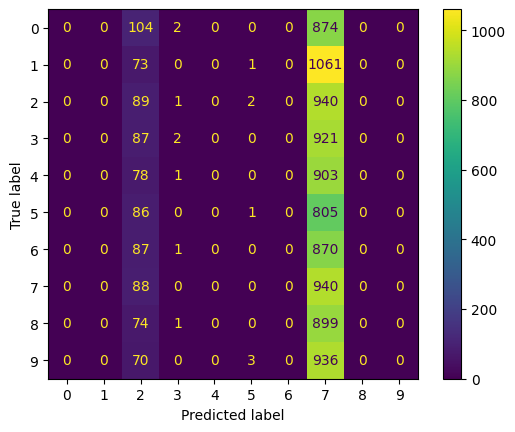

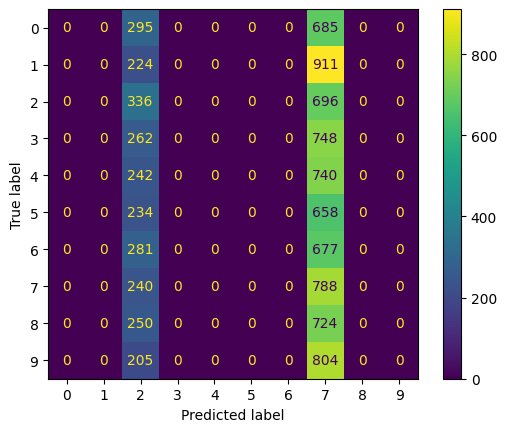

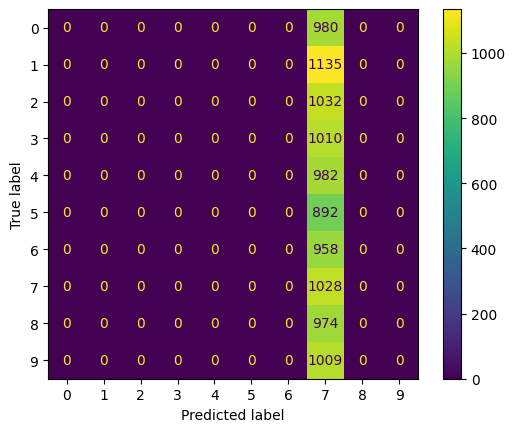

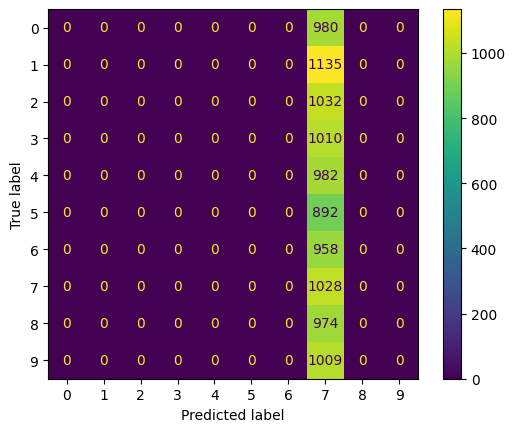

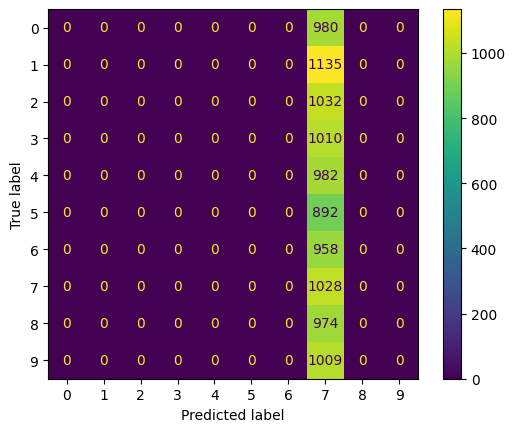

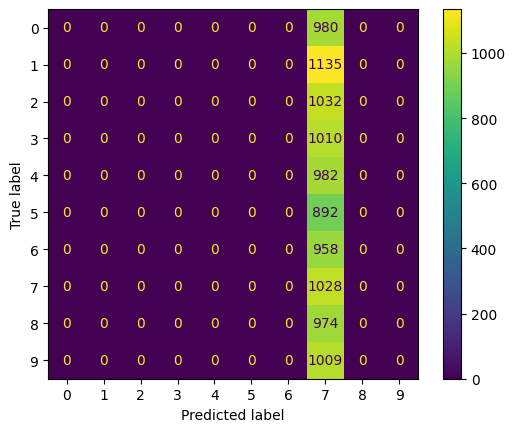

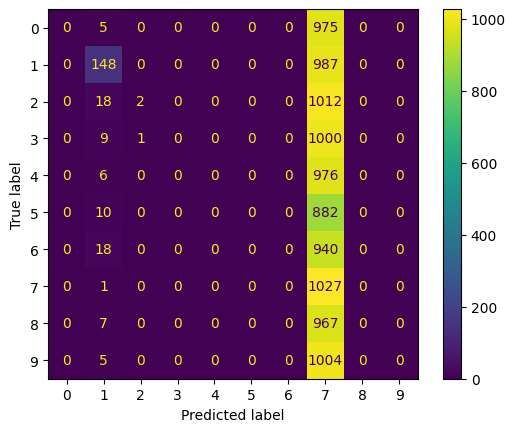

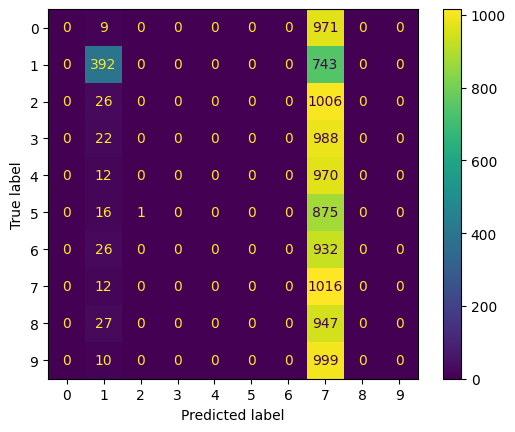

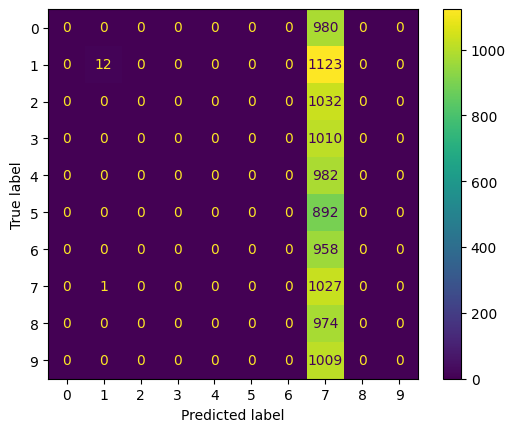

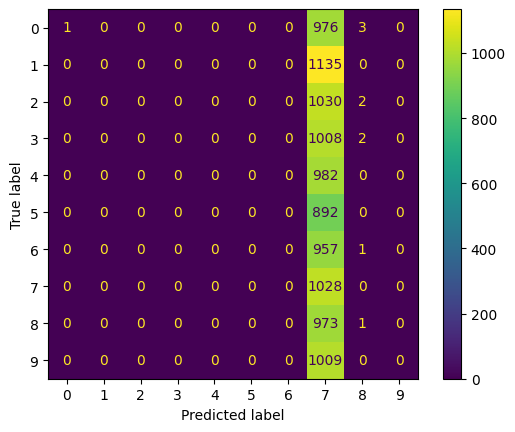

In [12]:
# First run
mlflow.start_run(run_name="I_name_this_non_pretrain_one")

model = alexnet(weights=None)
# replace the first layer to 1 channel
model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
# Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
# replace the last layer with out 10 features for MNIST
model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=10, bias=True)

# You can log the parameter and use the logged value like this
## lr = mlflow.log_param(key='lr',value=0.01)
## momentum = mlflow.log_param(key='momentum',value=0.9)
# Or you can log every params in the dict format
# https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.log_params
params = {"lr": 0.01, "momentum": 0.9, "batch_size":100, "is_pretrain":False}
mlflow.log_params(params=params)
# A quick dirty way to unpack dictionary key,value to variable and value
for key,value in params.items():
    exec(f"{key}={value}")


J_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# At the time of writing this tutorial, all GPUs are allocated. Very sad.
model.to('cpu')

# For the sake of learning, I will log batch_size
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)

best_acc = 0
classes = (0,1,2,3,4,5,6,7,8,9)
for e in range(10):
    e_train_loss = 0
    e_train_acc = 0
    for b, (X, y) in enumerate(train_loader):
        yhat = model(X) #1. model
        # print(b, X.shape, y.shape, yhat.shape)
        train_loss = J_fn(yhat, y) #2. loss
        #2.1 collect the loss and acc
        # Loss
        optimizer.zero_grad() #3. zero_grad
        train_loss.backward() #4. backward
        optimizer.step() #5. step
        e_train_loss += train_loss.detach().cpu()
        # Accuracy
        values, predicted = torch.max(yhat.data, 1)
        e_train_acc += (predicted == y).sum().item()

        # I will train only 10 batch because it takes forever to train on CPU
        if(b > 10):
            break

    mlflow.log_metric('train_loss', e_train_loss, step=e)
    mlflow.log_metric('train_acc', e_train_acc/len(train_loader), step=e)

    e_test_loss = 0
    e_test_acc = 0
    test_predicted = []
    test_y = []

    with torch.no_grad():
        for b, (X, y) in enumerate(test_loader):
            yhat = model(X)
            test_loss = J_fn(yhat, y)
            #2.1 collect the loss and acc
            # Loss
            e_test_loss += test_loss.detach().cpu()
            # Accuracy
            values, predicted = torch.max(yhat.data, 1)
            e_test_acc += (predicted == y).sum().item()

            # For confusion matrix
            test_predicted.extend(predicted.numpy()) # Save Prediction
            
            y = y.data.cpu().numpy()
            test_y.extend(y) # Save Truth
    
    mlflow.log_metric('test_loss', e_test_loss, step=e)
    mlflow.log_metric('test_acc', e_test_acc/len(test_loader), step=e)

    # Confusion Matrix
    cm = confusion_matrix(test_y, test_predicted, labels=classes)
    fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig.plot()
    mlflow.log_figure(fig.figure_, f"confusion_test_{e}.png")
    
    if(e_test_acc > best_acc):
        mlflow.pytorch.log_model(pytorch_model=model,artifact_path="model")

mlflow.end_run()


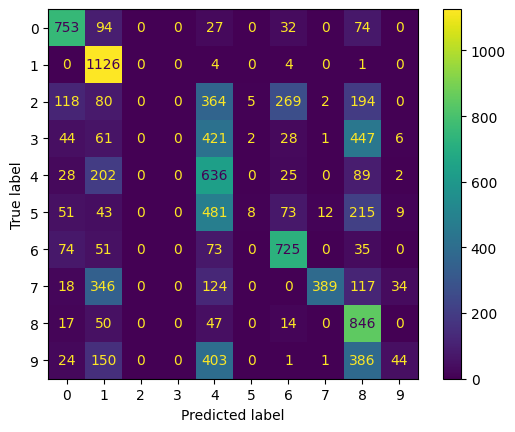

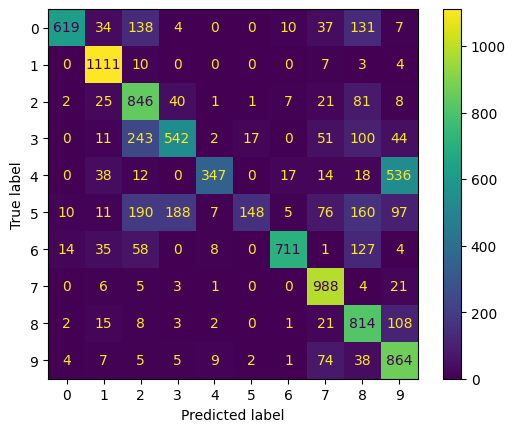

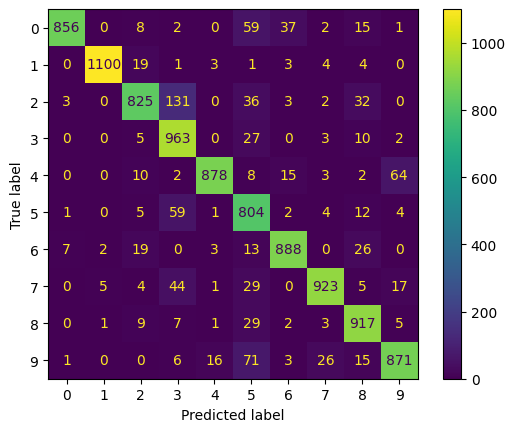

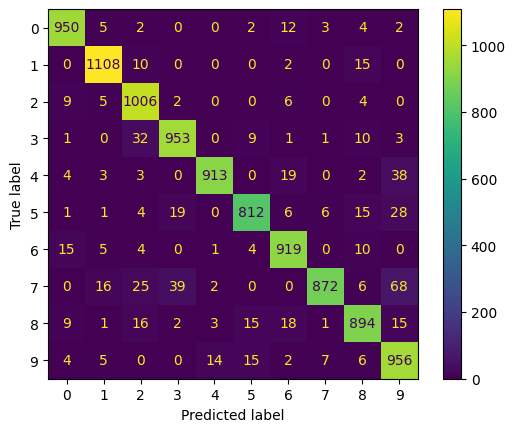

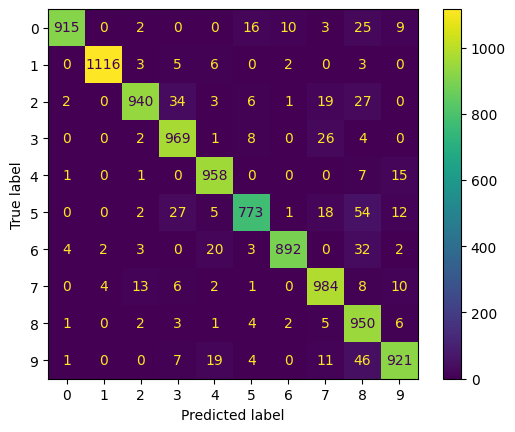

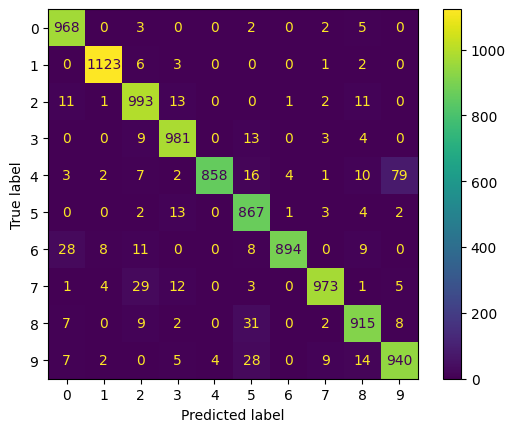

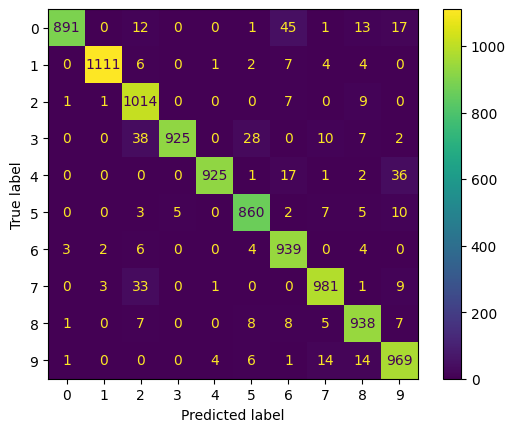

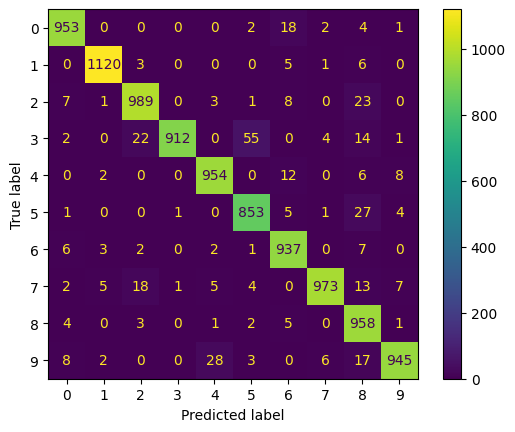

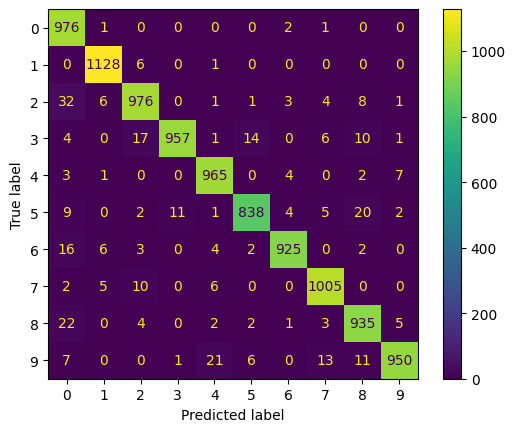

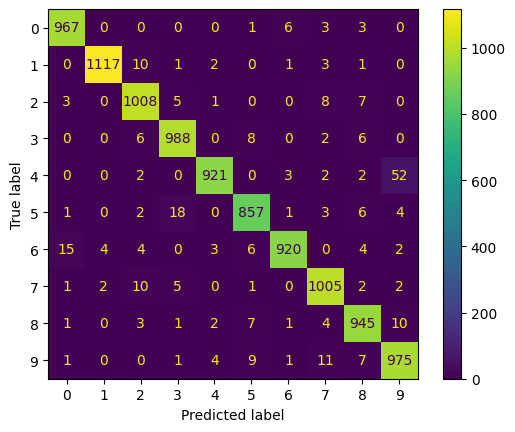

In [13]:
# Second run
# This time I use `with` syntax
with mlflow.start_run(run_name="I_name_this_pretrain_one") as run:
    
    model = alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
    # It the same code again
    
    # replace the first layer to 1 channel
    model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    # Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    # replace the last layer with out 10 features for MNIST
    model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=10, bias=True)
    
    params = {"lr": 0.01, "momentum": 0.9, "batch_size":100, "is_pretrain":True}
    mlflow.log_params(params=params)
    for key,value in params.items():
        exec(f"{key}={value}")
    
    
    J_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    model.to('cpu')
    
    train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)
    
    best_acc = 0
    classes = (0,1,2,3,4,5,6,7,8,9)
    for e in range(10):
        e_train_loss = 0
        e_train_acc = 0
        for b, (X, y) in enumerate(train_loader):
            yhat = model(X) #1. model
            # print(b, X.shape, y.shape, yhat.shape)
            train_loss = J_fn(yhat, y) #2. loss
            #2.1 collect the loss and acc
            # Loss
            optimizer.zero_grad() #3. zero_grad
            train_loss.backward() #4. backward
            optimizer.step() #5. step
            e_train_loss += train_loss.detach().cpu()
            # Accuracy
            values, predicted = torch.max(yhat.data, 1)
            e_train_acc += (predicted == y).sum().item()
    
            # I will train only 10 batch because it takes forever to train on CPU
            if(b > 10):
                break
    
        mlflow.log_metric('train_loss', e_train_loss, step=e)
        mlflow.log_metric('train_acc', e_train_acc/len(train_loader), step=e)
    
        e_test_loss = 0
        e_test_acc = 0
        test_predicted = []
        test_y = []
    
        with torch.no_grad():
            for b, (X, y) in enumerate(test_loader):
                yhat = model(X)
                test_loss = J_fn(yhat, y)
                #2.1 collect the loss and acc
                # Loss
                e_test_loss += test_loss.detach().cpu()
                # Accuracy
                values, predicted = torch.max(yhat.data, 1)
                e_test_acc += (predicted == y).sum().item()
    
                # For confusion matrix
                test_predicted.extend(predicted.numpy()) # Save Prediction
                
                y = y.data.cpu().numpy()
                test_y.extend(y) # Save Truth
        
        mlflow.log_metric('test_loss', e_test_loss, step=e)
        mlflow.log_metric('test_acc', e_test_acc/len(test_loader), step=e)
    
        # Confusion Matrix
        cm = confusion_matrix(test_y, test_predicted, labels=classes)
        fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        fig.plot()
        mlflow.log_figure(fig.figure_, f"confusion_test_{e}.png")
        
        if(e_test_acc > best_acc):
            mlflow.pytorch.log_model(pytorch_model=model,artifact_path="model")
    
    mlflow.end_run()


You can see that the parameters are now updated and I can now also look at the metrics.

![](../imgs/mlflow-alexnet-parameter.png)

If we look into the run details, we can plot the metrics.
No we are no longer needed to save the loss/accuracy in the array and plot it.

![](../imgs/mlflow-metric.png)

The Figure we saved are also located here in the artifact folders.
There are other kind of artifact, you will have to explore them yourselve.

![](../imgs/mlflow-artifact.png)

One good feature of `MLflow` is you can check which parameter give you improvment.
In this term, which paramter improve the "DV" or "Accuracy".

We use `Test Accuracy`.

Here you click the `Chart View` and select the parameter/metric you want to compare.

![](../imgs/mlflow-chartview.png)

As you can see, the red line here plot the configuration of `I_name_this_pretrain_one`.
The combination `batch_size=100`, `is_pretrain=True`, `lr=0.01`, `momentum=0.9` yields very high `test_acc`.



# Inference/Deploy

Let's say we are now happy with the result and want to deploy the model.

If you take a look back in to the training code, you will see I have saved the best model but where is it?

The model is one of the artifacts. Thus, you can find your saved model in the `Artifacts` section.
You can click the `download button` to download the model. 

![](../imgs/mlflow-download-model.png)

Or, if you register the model. It can be called via `MLflow` API.
You can imaging that when you find a better model and want to deploy it, all you need to do is register a new model. That is it.

![](../imgs/mlflow-apiprediction.png)